# Задания кратко

1. Задача – используя Python сделать прогноз на месяц вперед по каждому магазину.

2. Сделать прогноз по каждому магазину-дню на 3 месяца вперед.*


In [1]:
import pandas as pd
df = pd.read_excel(r'data\Train.xlsx')
print(df)

       Store       Date  Sales   MON_DATE
0         25 2015-06-30  16572 2015-06-01
1         94 2015-06-30  10792 2015-06-01
2        116 2015-06-30   9230 2015-06-01
3        155 2015-06-30  11461 2015-06-01
4        174 2015-06-30   8327 2015-06-01
...      ...        ...    ...        ...
20255    841 2013-01-02   3038 2013-01-01
20256    934 2013-01-02   5340 2013-01-01
20257    941 2013-01-02   4179 2013-01-01
20258    942 2013-01-02   3941 2013-01-01
20259   1045 2013-01-02   8282 2013-01-01

[20260 rows x 4 columns]


# Задание 1

### Cделать прогноз на месяц вперед по каждому магазину.

Сгруппируем данные, чтобы получить продажи за месяц

In [2]:
monthly_data=df.groupby(['Store','MON_DATE'],as_index=False).sum()
monthly_data.sort_values(by=['MON_DATE'])
monthly_data.rename(columns={"Sales": "MON_SALES"},inplace=1)

In [3]:
monthly_data

,Store,MON_DATE,MON_SALES
0,25,2013-01-01,279981
1,25,2013-02-01,256058
2,25,2013-03-01,302119
3,25,2013-04-01,334527
4,25,2013-05-01,314546
...,...,...,...
796,1081,2015-02-01,126922
797,1081,2015-03-01,148521
798,1081,2015-04-01,143705
799,1081,2015-05-01,178810


Количество магазинов в выборке

In [4]:
all_stores_id = df['Store'].unique()
len(all_stores_id)

28

In [5]:
import matplotlib.pyplot as plt

# function to draw all plots
def draw_all_graphs(elements_lables, data):
    # width = sqrt(elements_number)
    width = 4
    height = 7
    elements_number=len(elements_lables)
    fig, axs = plt.subplots(height,width,sharex=True)
    fig.set_figwidth(20)
    fig.set_figheight(35)
    fig.autofmt_xdate(rotation=90)
    for i in range(elements_number):
        data_to_draw = data[data['Store'] == elements_lables[i]]
        axs[i//width, i%width].plot(data_to_draw['MON_DATE'], data_to_draw['MON_SALES'])
        axs[i//width, i%width].set_title('Store num ' + str(elements_lables[i]))

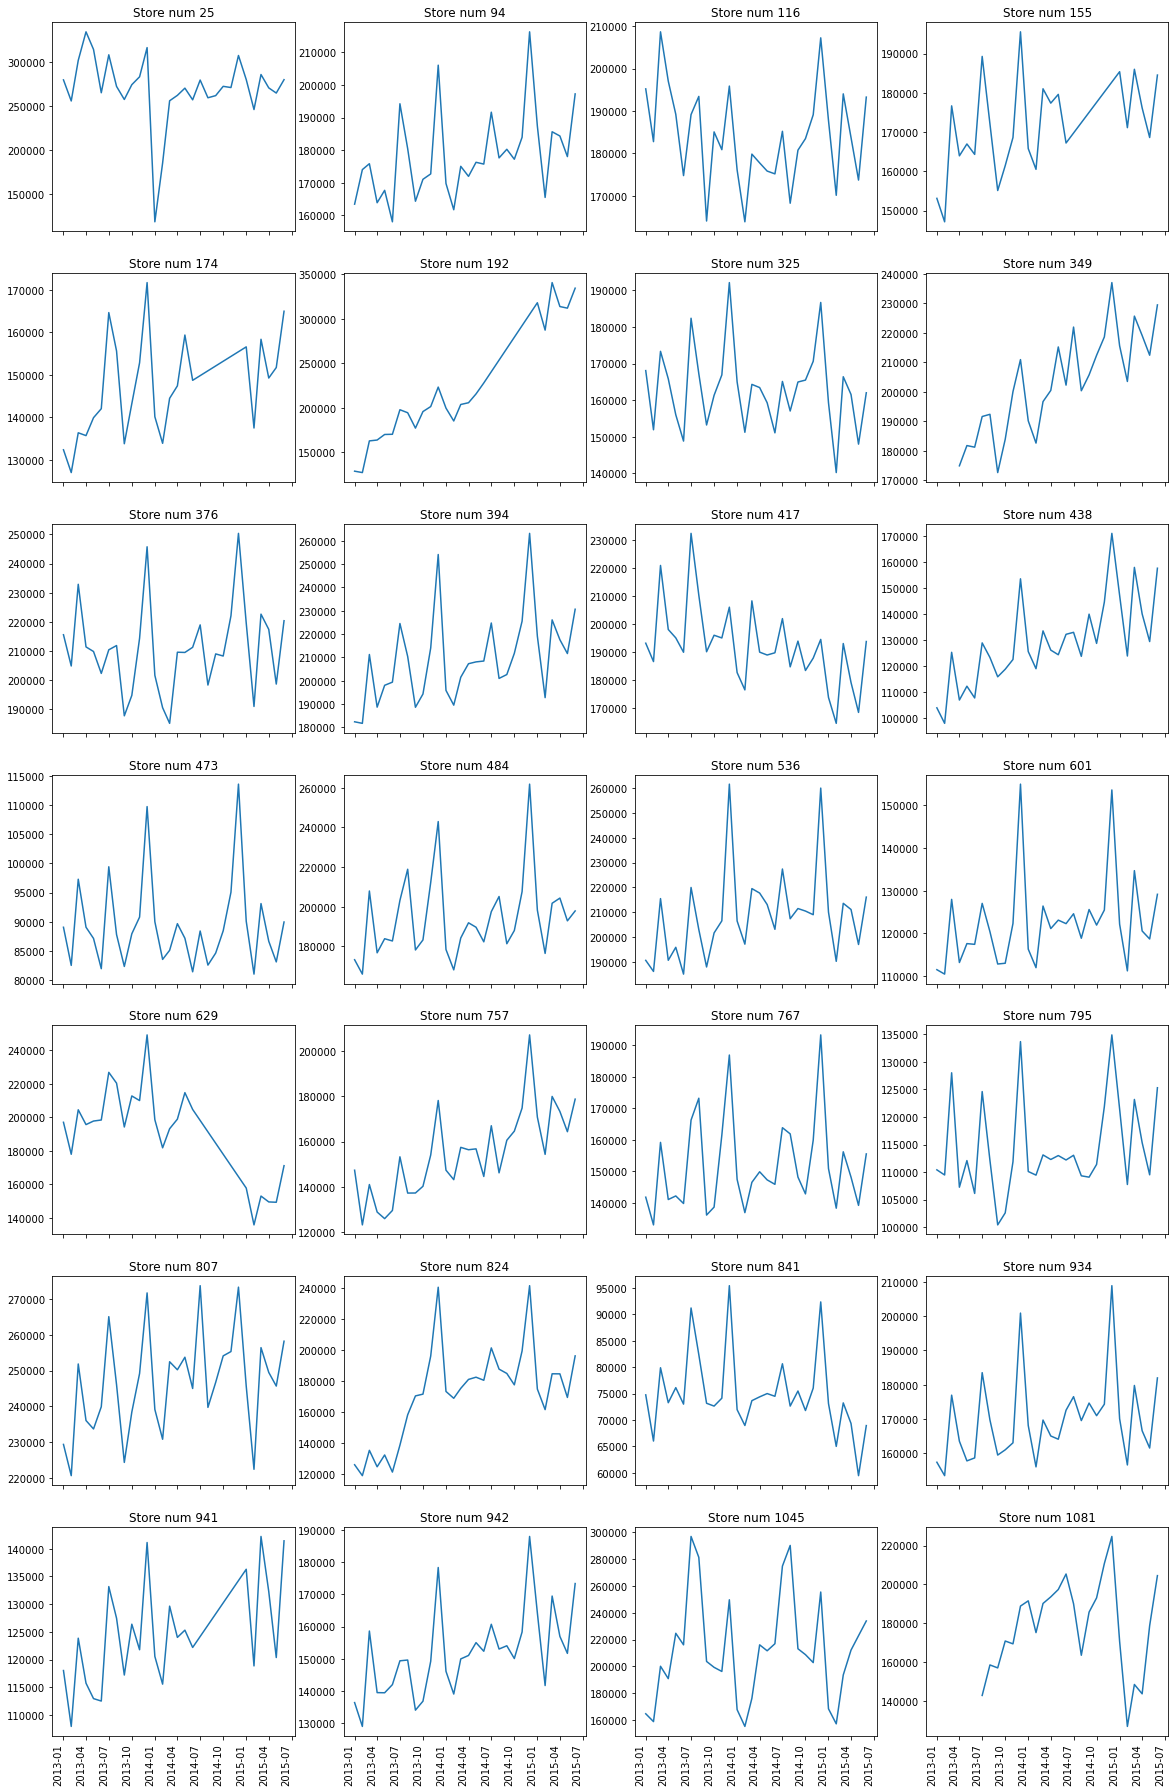

In [6]:
draw_all_graphs(all_stores_id,monthly_data)

##### По данным графикам можно сделать следующие выводы:
    1. Поведение от магазина к магазину может отличаться   
        => скорее всего стоит предсказывать для каждого магазина в отдельности. Для каждого ряда сторим свою модель в статметодах, id магазина это отдельная фича для ml
        
    2. В данных для некоторых магазинов существуют пропуски. Для стат методов нужно будет придумать как заполнить пропуски, в ml можно с пропусками

Метрика по которой будем оценивать качество предсказаний

In [7]:
def get_score(predicted_values,true_values):
    wape=0
    true_sum=0
    
    if(len(predicted_values)!=len(true_values)):
        print("Размеры векторов не совпдают!!!!!!")
        return 1000000 # means predictions doesn't match expected size, sth wrong
    
    # get total sum
    for elem in true_values:
        true_sum=true_sum+abs(elem)
        
    for i in range(len(predicted_values)):
        wape = wape + abs(predicted_values[i]-true_values[i])
    
    wape = wape/true_sum # weight
    return wape

# ML-методы

In [8]:
monthly_data=monthly_data.set_index("MON_DATE")

In [9]:
monthly_data.index

DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01',
               ...
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01'],
              dtype='datetime64[ns]', name='MON_DATE', length=801, freq=None)

In [10]:
def create_features_v1(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    
    # has_major_holiday_coming accounts for new year and may holidays 
    df['has_major_holiday_coming'] = 0
    df.loc[df['month'] == 12 , 'has_major_holiday_coming'] = 1
    df.loc[df['month'] == 5 , 'has_major_holiday_coming'] = 1
    return df

In [11]:
train = monthly_data.loc[monthly_data.index < '06-01-2015']
test = monthly_data.loc[monthly_data.index >= '06-01-2015']

In [12]:
train = create_features_v1(train)
test = create_features_v1(test)

In [13]:
FEATURES = ['Store','dayofyear','dayofmonth', 'dayofweek', 'year', 'quarter', 'month','has_major_holiday_coming']

TARGET = 'MON_SALES'

In [14]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
# allows not to repeat urself all the time
def train_and_evaluate(model, X_train, y_train, X_test, y_test,fit_params={}):
    model.fit(X_train, y_train, **fit_params)
    print(str(model))
    print("WAPE score is ", get_score(model.predict(X_test),y_test))
    return y_test,model.predict(X_test)

In [16]:
def plot_to_compare_predictions_for_all_stores(true,predicted):
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(9)
    ax.bar(list(map(str, all_stores_id)), true,label='true value')
    ax.bar(list(map(str, all_stores_id)), predicted,alpha=0.7,label='predicted value')
    ax.set_title('True vs Predicted next month for stores')
    ax.legend()
    plt.xticks(rotation=90)

In [17]:
train.index


DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01',
               ...
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01'],
              dtype='datetime64[ns]', name='MON_DATE', length=773, freq=None)

Для валидации берем последний месяц

In [18]:
train = monthly_data.loc[monthly_data.index < '06-01-2015']
test = monthly_data.loc[monthly_data.index >= '06-01-2015']

In [19]:
train = create_features_v1(train)
test = create_features_v1(test)

In [20]:
FEATURES = ['Store','dayofyear','dayofmonth', 'dayofweek', 'year', 'quarter', 'month','has_major_holiday_coming','weekofyear']

TARGET = 'MON_SALES'

In [21]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Бейзлайн

В качестве бейзлайна используем линейную регрессию

In [22]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
true,predicted=train_and_evaluate(linear_reg, X_train, y_train, X_test, y_test)

LinearRegression()
WAPE score is  0.20752975846571017


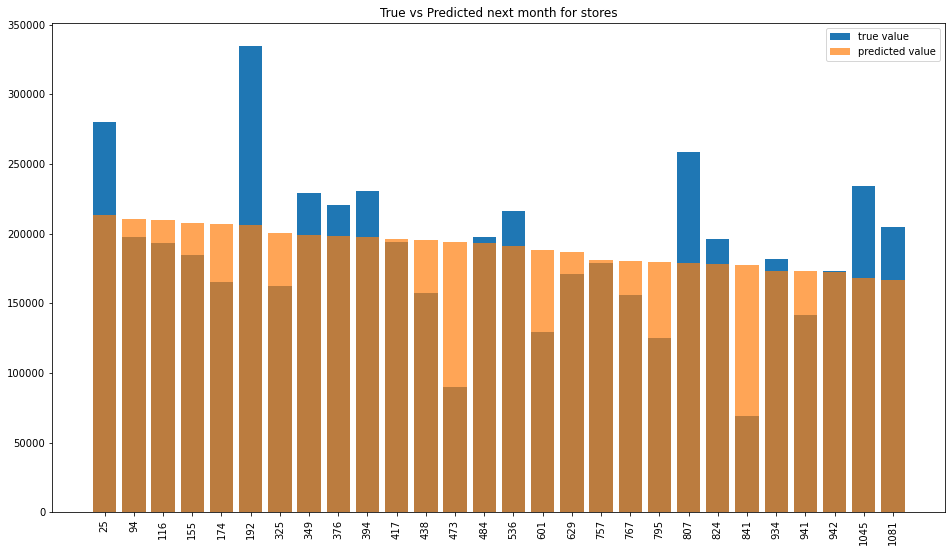

In [23]:
plot_to_compare_predictions_for_all_stores(true,predicted)


проверим как справляется svm

In [24]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svm_reg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
train_and_evaluate(svm_reg, X_train, y_train, X_test, y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])
WAPE score is  0.21968286276613125


(MON_DATE
 2015-06-01    280229
 2015-06-01    197228
 2015-06-01    193259
 2015-06-01    184521
 2015-06-01    164932
 2015-06-01    334330
 2015-06-01    162037
 2015-06-01    229401
 2015-06-01    220379
 2015-06-01    230666
 2015-06-01    193746
 2015-06-01    157504
 2015-06-01     89950
 2015-06-01    197845
 2015-06-01    216066
 2015-06-01    129171
 2015-06-01    171068
 2015-06-01    178801
 2015-06-01    155577
 2015-06-01    125311
 2015-06-01    258185
 2015-06-01    196085
 2015-06-01     68947
 2015-06-01    182003
 2015-06-01    141421
 2015-06-01    173316
 2015-06-01    233823
 2015-06-01    204558
 Name: MON_SALES, dtype: int64,
 array([172600.43652064, 172599.53488111, 172599.16148682, 172598.39934839,
        172597.98263164, 172597.56114986, 172593.71712909, 172592.90525564,
        172591.95739411, 172591.30740023, 172590.45845776, 172589.66778456,
        172588.32392207, 172587.89638665, 172585.85682182, 172583.3106225 ,
        172582.23271643, 172577.646554

ридж, лассо примерно такие же результаты без заметных улучшений

Используем бустинг как один из самых эффективных и полезных и т.к. xgboost на практике используется для предсказания временных рядов

### Бустинг

In [25]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=10000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=7,
                       learning_rate=0.007
                          )

true,predicted=train_and_evaluate(xgb_reg, X_train, y_train, X_test, y_test,
                   dict(eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100))

[22:07:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:07:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:177629.04688	validation_1-rmse:194469.42188
[100]	validation_0-rmse:92154.17188	validation_1-rmse:108884.82031
[200]	validation_0-rmse:50167.28516	validation_1-rmse:64047.91797
[300]	validation_0-rmse:29048.92578	validation_1-rmse:41227.53906
[400]	validation_0-rmse:18681.77539	validation_1-rmse:29699.81250
[500]	validation_0-rmse:13534.39160	validation_1-rmse:23638.54

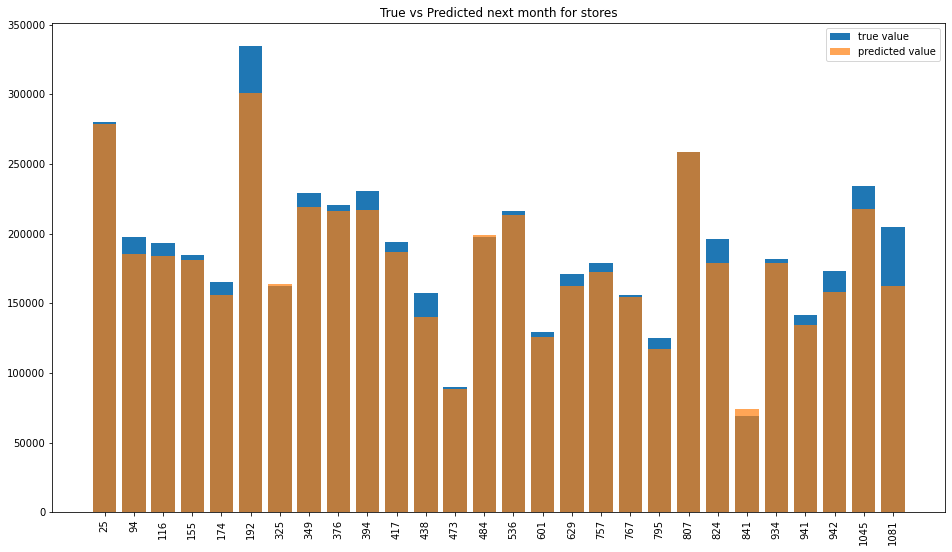

In [26]:
plot_to_compare_predictions_for_all_stores(true,predicted)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

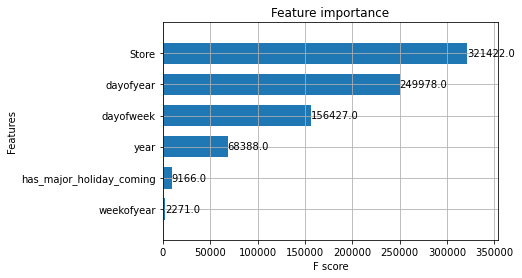

In [27]:
plot_importance(xgb_reg, height=0.7)

Оставим только "важные фичи"

In [28]:
FEATURES = ['dayofyear', 'dayofweek', 'year','has_major_holiday_coming','weekofyear','Store']
X_train = train[FEATURES]
X_test = test[FEATURES]

In [29]:
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=7,
                       learning_rate=0.007
                          )

true,predicted=train_and_evaluate(xgb_reg, X_train, y_train, X_test, y_test,
                   dict(eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100))

[22:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:177629.04688	validation_1-rmse:194469.42188
[100]	validation_0-rmse:92154.17188	validation_1-rmse:108884.82031
[200]	validation_0-rmse:50167.28516	validation_1-rmse:64047.91797
[300]	validation_0-rmse:29048.92578	validation_1-rmse:41227.53906
[400]	validation_0-rmse:18681.77539	validation_1-rmse:29699.81250
[500]	validation_0-rmse:13534.39160	validation_1-rmse:23638.54

Качество не особо меняется поэтому вернем как было

Заметим что в нашей моделе id магазина задается как целое число. На самом же деле id магазина это скорее категориальный признак. Проверим улучшится ли качество, если создать дамми-признак для каждого магазина

In [30]:
def create_features_v2(df):
    """
    Create time series features based on time series index.
    """
    df = create_features_v1(df)
    
    for store_id in all_stores_id:
        name = "store is " + str(store_id)
        df[name]=0
        df.loc[df['Store'] == store_id , name] = 1
    
    return df

In [31]:
train_v2 = create_features_v2(train)
test_v2 = create_features_v2(test)

In [32]:
FEATURES_v2 = test_v2.columns.to_list()[2:]
FEATURES_v2

['dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'has_major_holiday_coming',
 'store is 25',
 'store is 94',
 'store is 116',
 'store is 155',
 'store is 174',
 'store is 192',
 'store is 325',
 'store is 349',
 'store is 376',
 'store is 394',
 'store is 417',
 'store is 438',
 'store is 473',
 'store is 484',
 'store is 536',
 'store is 601',
 'store is 629',
 'store is 757',
 'store is 767',
 'store is 795',
 'store is 807',
 'store is 824',
 'store is 841',
 'store is 934',
 'store is 941',
 'store is 942',
 'store is 1045',
 'store is 1081']

In [33]:
X_train_v2 = train_v2[FEATURES_v2]
y_train_v2 = train_v2[TARGET]

X_test_v2 = test_v2[FEATURES_v2]
y_test_v2 = test_v2[TARGET]

In [34]:
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2100,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=7,
                       learning_rate=0.007,
                          reg_lambda=0.1)

true,predicted=train_and_evaluate(xgb_reg, X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                   dict(eval_set=[(X_train_v2, y_train_v2), (X_test_v2, y_test_v2)],verbose=100))

[22:08:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:177618.21875	validation_1-rmse:194456.04688
[100]	validation_0-rmse:91323.99219	validation_1-rmse:108175.54688
[200]	validation_0-rmse:49733.36719	validation_1-rmse:65210.10547
[300]	validation_0-rmse:29752.87891	validation_1-rmse:43297.78125
[400]	validation_0-rmse:20209.26562	validation_1-rmse:31603.22266
[500]	validation_0-rmse:15301.40723	validation_1-rmse:24950.05

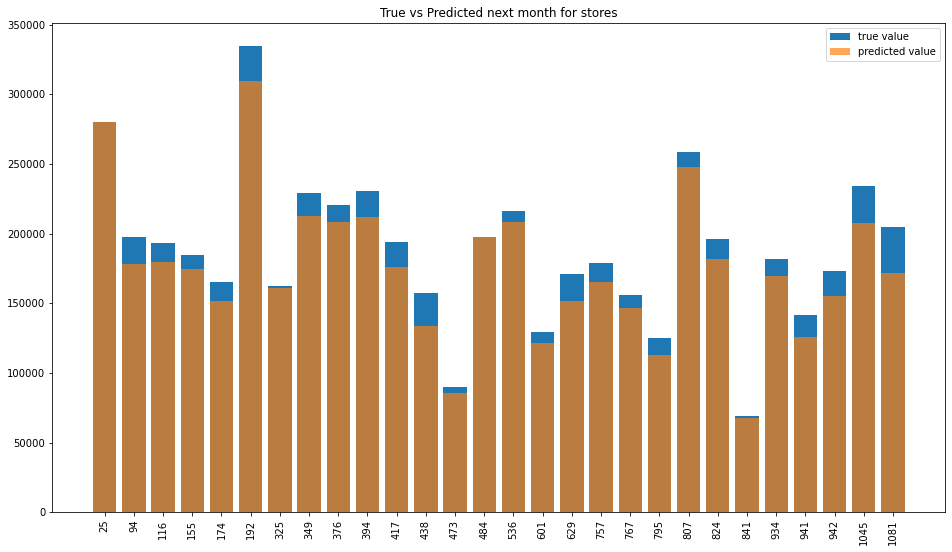

In [35]:
plot_to_compare_predictions_for_all_stores(true,predicted)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

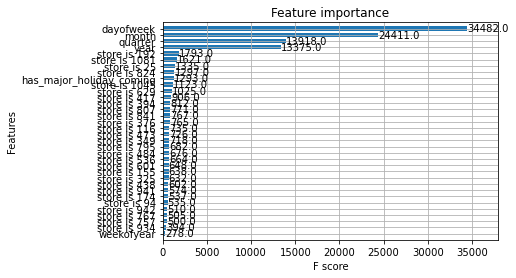

In [36]:
plot_importance(xgb_reg, height=0.7)

Улучшений не набдается. Значит остановимся на первой спецификации бустинга

P.S.
Интуитивно кажется, что при работе с данными по месяцам, не имеет смысла брать такие фичи как день месяца/года т.к. они либо имеют нулевую вариативность, либо однозначно соотностся с другими характеристиками (месяц).  Однако сравнив качество моделей, было замечено что одна и та же спецификация бустинга добивается более высокого качества при использовании таких фич.

## Выбор параметров бустинга

можно было бы использовать библеотеки выбора параметров оптимизации, но в данной ситуации и при ручном выборе стало примерно понятно какие значения являются оптимальными.

In [37]:
FEATURES = ['Store','dayofyear','dayofmonth', 'dayofweek', 'year', 'quarter', 'month','has_major_holiday_coming','weekofyear']

In [38]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [39]:
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2400,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=7,
                       learning_rate=0.007,
                          reg_lambda=0.9)

true,predicted=train_and_evaluate(xgb_reg, X_train, y_train, X_test, y_test,
                   dict(eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100))

[22:08:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:177627.07812	validation_1-rmse:194470.70312
[100]	validation_0-rmse:92048.43750	validation_1-rmse:108617.05469
[200]	validation_0-rmse:49961.35938	validation_1-rmse:63637.40625
[300]	validation_0-rmse:28867.91797	validation_1-rmse:40940.64453
[400]	validation_0-rmse:18551.65234	validation_1-rmse:29211.25195
[500]	validation_0-rmse:13393.86523	validation_1-rmse:23167.84

#### WAPE score is  0.043360025083205904


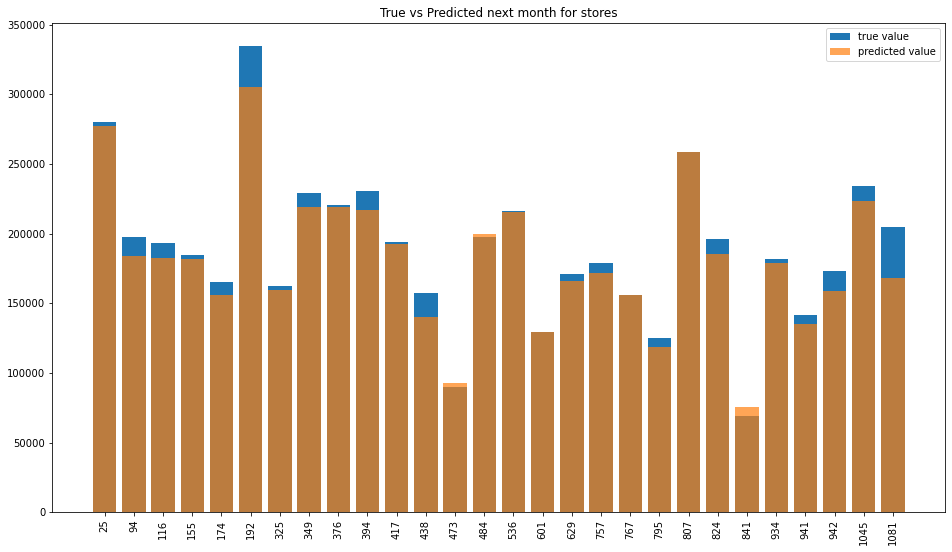

In [40]:
plot_to_compare_predictions_for_all_stores(true,predicted)

смещения от reg_lambda 0.9 на 0.01 уже заметно снижают качество

деревья глубины больше 7 начинают быстро переобучаться, с меньшей глубиной не могут подобраться к такому же качеству

минимум на валидации при н=2400

## Альтернативные ML подходы

Можно было бы еще пробовать рекуррентные сети, но т.к. время огранично и учитывается, эта идея была оставлена.
https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en

# Классические методы

In [41]:
monthly_data

,Store,MON_SALES
MON_DATE,,
2013-01-01,25,279981
2013-02-01,25,256058
2013-03-01,25,302119
2013-04-01,25,334527
2013-05-01,25,314546
...,...,...
2015-02-01,1081,126922
2015-03-01,1081,148521
2015-04-01,1081,143705


# Статистические методы

В иделе для использования этих методов нужно детально изучать различные графики, чтобы подобрать оптимальные коэфы и т.п. Здесь они используются в большей степени чтобы сравнить с бустингом (удастся ли простым перебором параметров получить качество получше), чтобы выбрать для финальных предсказаний модель посильнее.

Для использования статистических методов необходимо каким-то образом заполнить отсутствующие значения.

In [42]:
monthly_data_stat=monthly_data.copy()
all_mon_dates = monthly_data_stat.index.unique().to_list()
len(all_mon_dates)

30

In [43]:
all_stores_by_mon = [ (i, j)
                     for i in all_stores_id
                     for j in all_mon_dates ]
all_stores_by_mon = pd.DataFrame(all_stores_by_mon,columns=['Store','MON_DATE'])


In [44]:
monthly_data_stat.reset_index()

,MON_DATE,Store,MON_SALES
0,2013-01-01,25,279981
1,2013-02-01,25,256058
2,2013-03-01,25,302119
3,2013-04-01,25,334527
4,2013-05-01,25,314546
...,...,...,...
796,2015-02-01,1081,126922
797,2015-03-01,1081,148521
798,2015-04-01,1081,143705
799,2015-05-01,1081,178810


In [45]:
monthly_data_stat_with_nans = all_stores_by_mon.join(monthly_data_stat.reset_index().set_index(['Store','MON_DATE']), on=['Store','MON_DATE'],how='left',rsuffix='_y')
monthly_data_stat_with_nans=monthly_data_stat_with_nans.set_index('MON_DATE')
monthly_data_stat_with_nans

,Store,MON_SALES
MON_DATE,,
2013-01-01,25,279981.0
2013-02-01,25,256058.0
2013-03-01,25,302119.0
2013-04-01,25,334527.0
2013-05-01,25,314546.0
...,...,...
2015-02-01,1081,126922.0
2015-03-01,1081,148521.0
2015-04-01,1081,143705.0


In [46]:
monthly_data_stat_with_nans[monthly_data_stat_with_nans['Store']==192].tail(20)

,Store,MON_SALES
MON_DATE,,
2013-11-01,192,201326.0
2013-12-01,192,223196.0
2014-01-01,192,199590.0
2014-02-01,192,185147.0
2014-03-01,192,203667.0
2014-04-01,192,205620.0
2014-05-01,192,215514.0
2014-06-01,192,227820.0
2014-07-01,192,NaN


## ARIMA

In [47]:
from statsmodels.tsa.arima.model import ARIMA

In [48]:
p=1
d=1
q=11
arima_models=[]
predicted_values=[]
true_values=[]
for store in all_stores_id:
    # current store data preparation
    time_series = monthly_data_stat_with_nans[monthly_data_stat_with_nans['Store']==store]['MON_SALES'].copy()
    # fill missing value, simpliest approach
    time_series=time_series.interpolate()
    train_series = time_series[:-1]
    test_series =  time_series[-1]
    #fit
    ARIMAmodel = ARIMA(train_series, order = (p, d, q))
    ARIMAmodel = ARIMAmodel.fit()
    arima_models.append(ARIMAmodel)
    #prediction
    pred = ARIMAmodel.forecast(1)
    true_values.append(test_series)
    predicted_values.append(pred[0])

C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\19ser\anaconda3\lib\site-packages

C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-pack

C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\19ser\anaconda3\lib\site-packages

C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few obser

In [49]:
print("WAPE SCORE IS ",get_score(true_values,predicted_values))

WAPE SCORE IS  0.0867702021187862


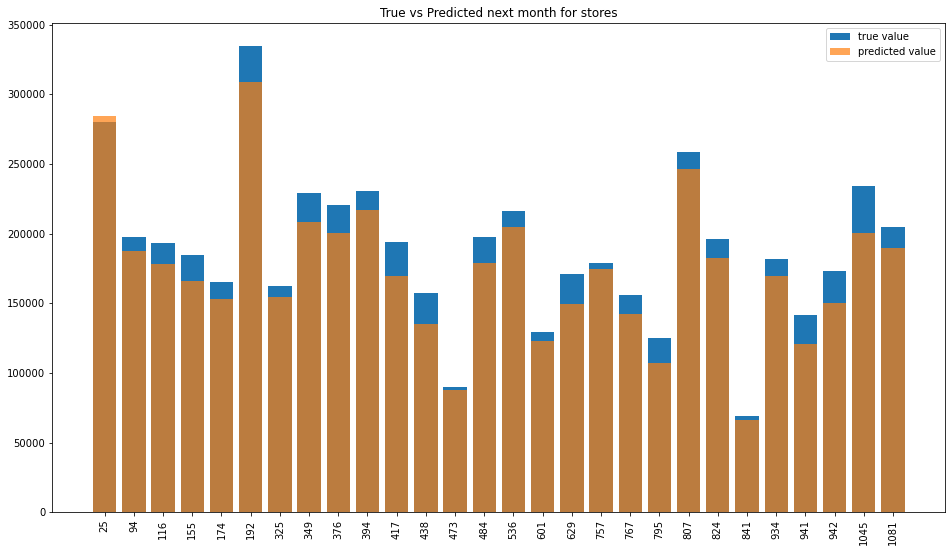

In [50]:
plot_to_compare_predictions_for_all_stores(true_values,predicted_values)

Хуже бустинга

## SARIMA

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p=1
d=1
q=11
P=0
D=0
Q=0
s=3
sarima_models=[]
predicted_values=[]
true_values=[]
for store in all_stores_id:
    # current store data preparation
    time_series = monthly_data_stat_with_nans[monthly_data_stat_with_nans['Store']==store]['MON_SALES'].copy()
    # fill missing value, simpliest approach
    time_series=time_series.interpolate()
    train_series = time_series[:-1]
    test_series =  time_series[-1]
    #fit
    SARIMAmodel = SARIMAX(train_series, order = (p, d, q))
    SARIMAmodel = SARIMAmodel.fit()
    sarima_models.append(ARIMAmodel)
    #prediction
    pred = ARIMAmodel.forecast(1)
    true_values.append(test_series)
    predicted_values.append(pred[0])

C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19ser\anaconda3\lib\site-pack

C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19ser\anaconda3\lib\site-pack

C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\19ser\anaconda3\lib\site-pack

In [52]:
print("WAPE SCORE IS ",get_score(true_values,predicted_values))

WAPE SCORE IS  0.20754689987536837


похоже что мало данных, при различных наборах параметров не удалось нормально обучится

Значит в качестве основной модели выбираем бустинг

# Задание 2

Сделать прогноз по каждому магазину-дню на 3 месяца вперед

Статистические модели не смогли себя хорошо зарекомендовать  в первом задании так что сразу возьмем бустинг (для экономии веремни)

In [53]:
daily_data = df.copy()
daily_data.drop(columns='MON_DATE',inplace=True)
daily_data=daily_data.set_index('Date')

In [54]:
daily_data.index

DatetimeIndex(['2015-06-30', '2015-06-30', '2015-06-30', '2015-06-30',
               '2015-06-30', '2015-06-30', '2015-06-30', '2015-06-30',
               '2015-06-30', '2015-06-30',
               ...
               '2013-01-02', '2013-01-02', '2013-01-02', '2013-01-02',
               '2013-01-02', '2013-01-02', '2013-01-02', '2013-01-02',
               '2013-01-02', '2013-01-02'],
              dtype='datetime64[ns]', name='Date', length=20260, freq=None)

хотим предсказывать 3 месяца вперед, поэтому валидация будет по 3ем (тест)

In [55]:
max(daily_data.index)

Timestamp('2015-06-30 00:00:00')

In [56]:
import dateutil.relativedelta

first_train_date= max(daily_data.index)-dateutil.relativedelta.relativedelta(months=3)

In [57]:
first_train_date

Timestamp('2015-03-30 00:00:00')

In [58]:
train_2 = daily_data.loc[daily_data.index < first_train_date]
test_2 = daily_data.loc[daily_data.index >= first_train_date]

In [59]:
test_2

,Store,Sales
Date,,
2015-06-30,25,16572
2015-06-30,94,10792
2015-06-30,116,9230
2015-06-30,155,11461
2015-06-30,174,8327
...,...,...
2015-03-30,934,11557
2015-03-30,941,9160
2015-03-30,942,11603


In [60]:
train_2=create_features_v1(train_2)
test_2=create_features_v1(test_2)
test_2

,Store,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,has_major_holiday_coming
Date,,,,,,,,,,
2015-06-30,25,16572,1,2,6,2015,181,30,27,0
2015-06-30,94,10792,1,2,6,2015,181,30,27,0
2015-06-30,116,9230,1,2,6,2015,181,30,27,0
2015-06-30,155,11461,1,2,6,2015,181,30,27,0
2015-06-30,174,8327,1,2,6,2015,181,30,27,0
...,...,...,...,...,...,...,...,...,...,...
2015-03-30,934,11557,0,1,3,2015,89,30,14,0
2015-03-30,941,9160,0,1,3,2015,89,30,14,0
2015-03-30,942,11603,0,1,3,2015,89,30,14,0


In [61]:
train_2

,Store,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,has_major_holiday_coming
Date,,,,,,,,,,
2015-03-29,1045,4972,6,1,3,2015,88,29,13,0
2015-03-29,1081,4117,6,1,3,2015,88,29,13,0
2015-03-28,25,8927,5,1,3,2015,87,28,13,0
2015-03-28,94,5957,5,1,3,2015,87,28,13,0
2015-03-28,116,7158,5,1,3,2015,87,28,13,0
...,...,...,...,...,...,...,...,...,...,...
2013-01-02,841,3038,2,1,1,2013,2,2,1,0
2013-01-02,934,5340,2,1,1,2013,2,2,1,0
2013-01-02,941,4179,2,1,1,2013,2,2,1,0


In [62]:
def compare_predicted_timeseries_for_each_store(elements_lables, data):
    # width = sqrt(elements_number)
    width = 4
    height = 7
    elements_number=len(elements_lables)
    fig, axs = plt.subplots(height,width,sharex=True)
    fig.set_figwidth(20)
    fig.set_figheight(35)
    fig.autofmt_xdate(rotation=90)
    for i in range(elements_number):
        data_to_draw = data[data['Store'] == elements_lables[i]]
        axs[i//width, i%width].plot(data_to_draw.index, data_to_draw['Sales'])
        axs[i//width, i%width].plot(data_to_draw.index, data_to_draw['pred'])
        axs[i//width, i%width].set_title('Store num ' + str(elements_lables[i]))

In [63]:
X_train_2 = train_2[FEATURES]
y_train_2 = train_2['Sales']

X_test_2 = test_2[FEATURES]
y_test_2 = test_2['Sales']

In [64]:
linear_reg = LinearRegression()
true,predicted = train_and_evaluate(linear_reg, X_train_2, y_train_2, X_test_2, y_test_2)

LinearRegression()
WAPE score is  0.28461834826930554


In [65]:
reg_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=10000,
                       early_stopping_rounds=100,
                       objective='reg:linear',
                       max_depth=10,
                       learning_rate=0.001)

true,predicted = train_and_evaluate(reg_xgb, X_train_2, y_train_2, X_test_2, y_test_2,
                                   dict(eval_set=[(X_train_2, y_train_2), (X_test_2, y_test_2)],verbose=100))

[22:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:7224.19727	validation_1-rmse:7897.49121
[100]	validation_0-rmse:6576.64111	validation_1-rmse:7241.86816
[200]	validation_0-rmse:5996.57520	validation_1-rmse:6652.09961
[300]	validation_0-rmse:5473.25977	validation_1-rmse:6121.23047
[400]	validation_0-rmse:4999.45996	validation_1-rmse:5635.39990
[500]	validation_0-rmse:4574.79834	validation_1-rmse:5202.20703
[600]	valid

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

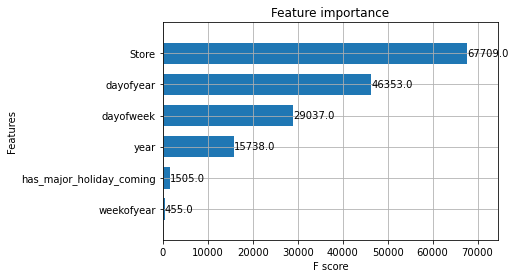

In [66]:
plot_importance(xgb_reg, height=0.7)

In [67]:
test_2_with_pred=test_2.copy()
test_2_with_pred['pred']=predicted
test_2_with_pred

,Store,Sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,has_major_holiday_coming,pred
Date,,,,,,,,,,,
2015-06-30,25,16572,1,2,6,2015,181,30,27,0,15796.080078
2015-06-30,94,10792,1,2,6,2015,181,30,27,0,8761.282227
2015-06-30,116,9230,1,2,6,2015,181,30,27,0,8393.343750
2015-06-30,155,11461,1,2,6,2015,181,30,27,0,8204.456055
2015-06-30,174,8327,1,2,6,2015,181,30,27,0,6779.573242
...,...,...,...,...,...,...,...,...,...,...,...
2015-03-30,934,11557,0,1,3,2015,89,30,14,0,12005.514648
2015-03-30,941,9160,0,1,3,2015,89,30,14,0,9274.428711
2015-03-30,942,11603,0,1,3,2015,89,30,14,0,10978.239258


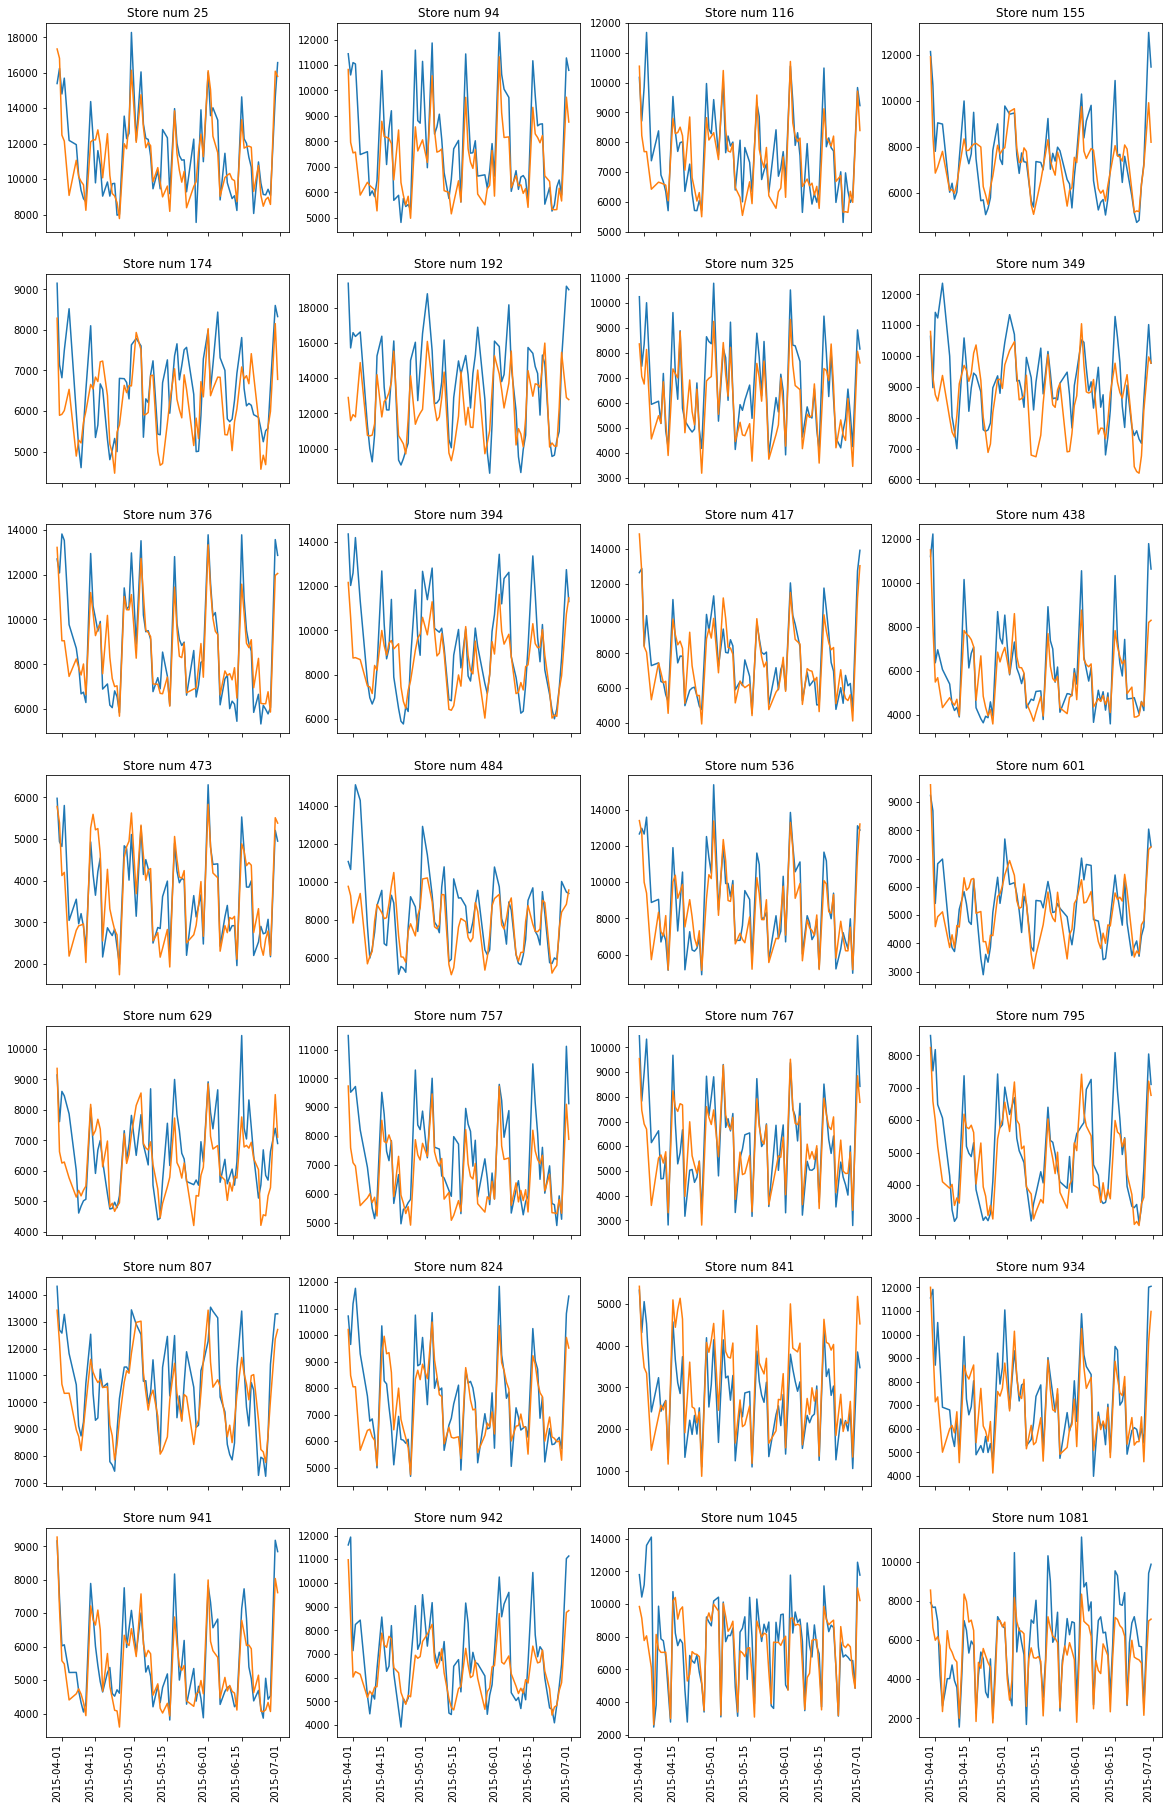

In [68]:
compare_predicted_timeseries_for_each_store(all_stores_id,test_2_with_pred)

# Поподбираем параметры
ниже лучшее чего удалось достичь

In [69]:
reg_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=3200,
                       early_stopping_rounds=100,
                       objective='reg:linear',
                       max_depth=8,
                       learning_rate=0.005)

true,predicted = train_and_evaluate(reg_xgb, X_train_2, y_train_2, X_test_2, y_test_2,
                                   dict(eval_set=[(X_train_2, y_train_2), (X_test_2, y_test_2)],verbose=100))

[22:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:7197.36230	validation_1-rmse:7870.37402
[100]	validation_0-rmse:4592.22607	validation_1-rmse:5220.73584
[200]	validation_0-rmse:3059.59692	validation_1-rmse:3650.78833
[300]	validation_0-rmse:2183.96777	validation_1-rmse:2744.63867
[400]	validation_0-rmse:1686.05078	validation_1-rmse:2201.28052
[500]	validation_0-rmse:1392.47803	validation_1-rmse:1858.02051
[600]	valid

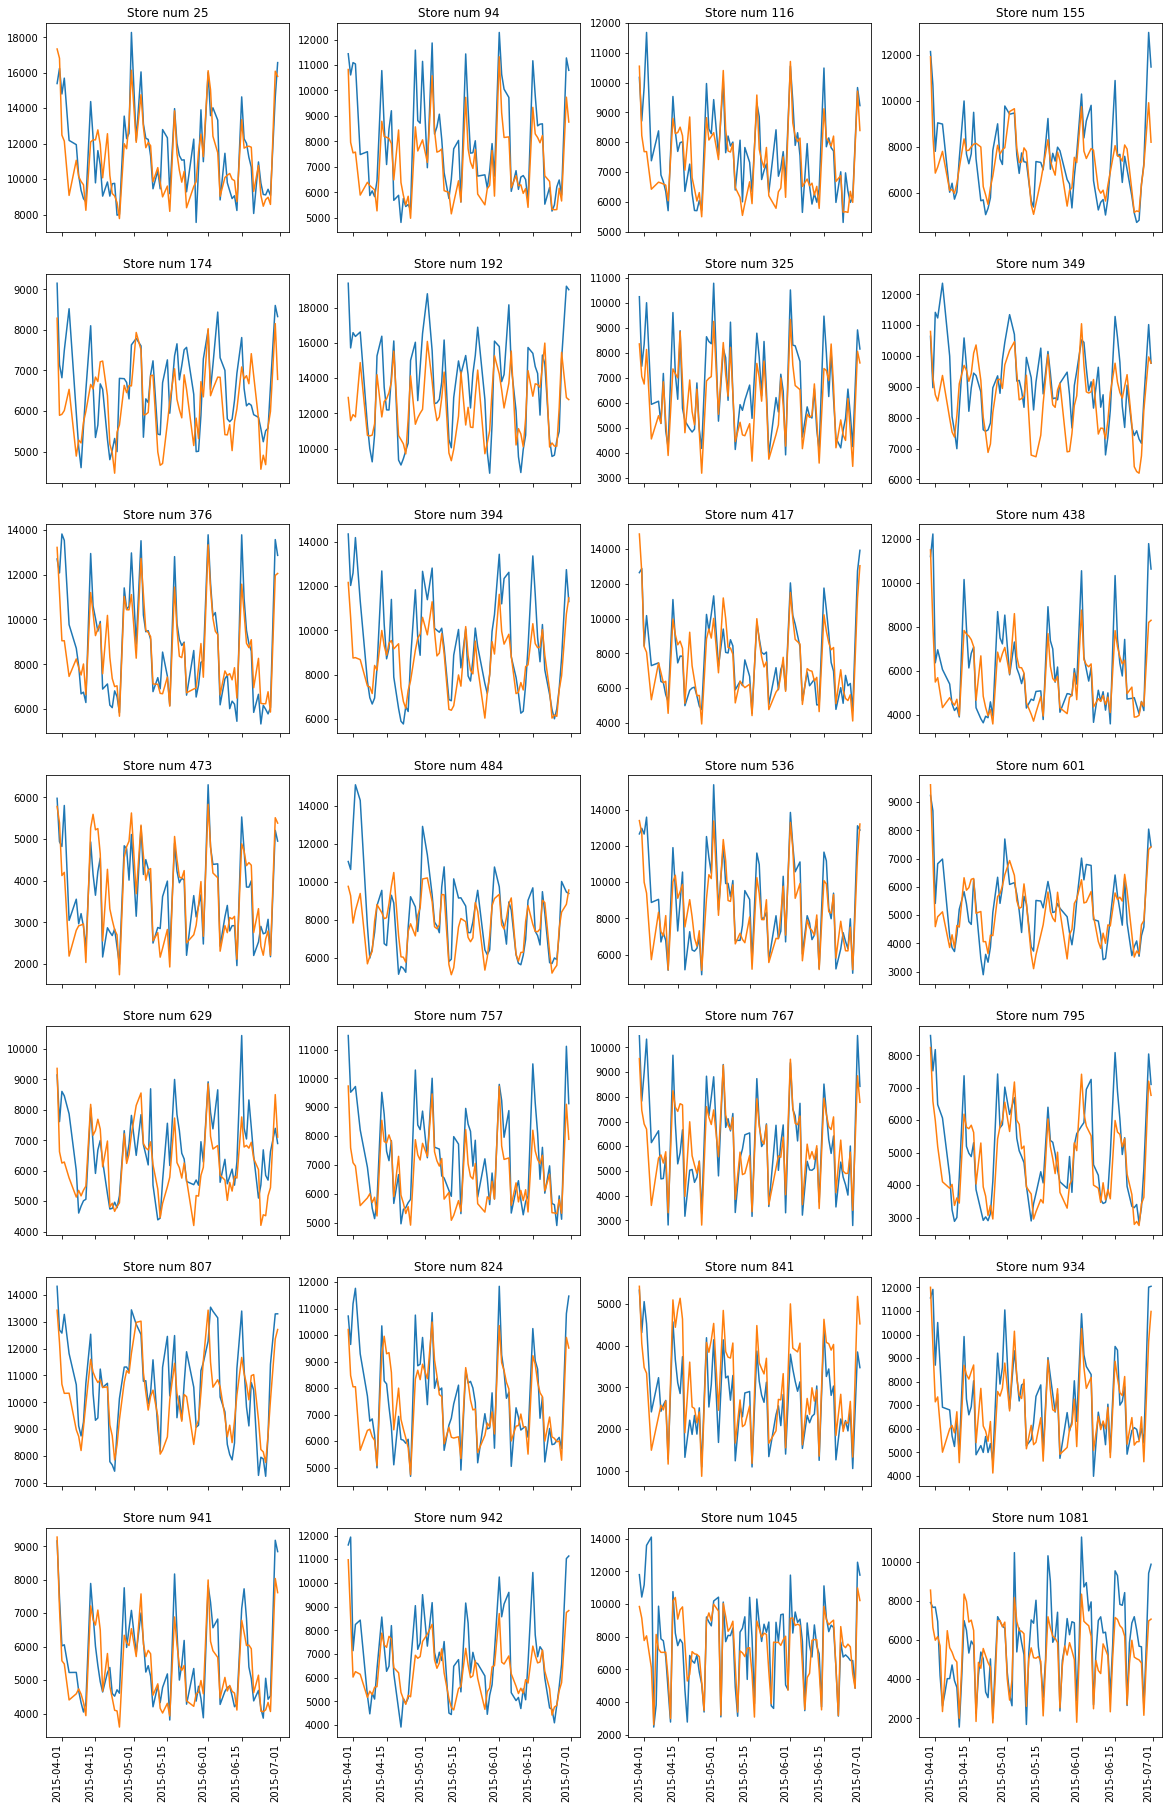

In [70]:
compare_predicted_timeseries_for_each_store(all_stores_id,test_2_with_pred)